In [ ]:
# TA-Lib 설치 코드
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler
import collections
import pandas as pd
from sklearn import datasets
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
from tqdm import tqdm
import matplotlib.pyplot as plt
%pylab inline
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report,confusion_matrix  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3745    0  3745    0     0  16142      0 --:--:-- --:--:-- --:--:-- 16142
100  503k  100  503k    0     0   952k      0 --:--:-- --:--:-- --:--:--  952k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3749    0  3749    0     0  17197      0 --:--:-- --:--:-- --:--:-- 17197
100  406k  100  406k    0     0   767k      0 --:--:-- --:--:-- --:--:--  767k
Populating the interactive namespace from numpy and matplotlib


# 데이터 불러오기(original)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/original_data.csv", index_col =['Date'], parse_dates=True)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,log_return,CCI,MA5,MA10,MA20,MA60,MA20_ratio,MA60_ratio,MA20_volume,MA60_volumne,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-04,7068.327148,7109.184570,6913.069336,7027.469727,6893.216309,2256630,1188.050049,410.359985,13.98,886.900024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,6913.069336,6978.440918,6815.011230,6945.754883,6813.062500,1773241,1183.739990,404.250000,14.09,885.190002,-0.011696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.714844,NaN,NaN,NaN
2005-01-06,6978.440918,7305.299805,6847.697266,6986.612305,6853.140137,7480900,1187.890015,402.140015,13.58,871.280029,0.005865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.857422,NaN,NaN,NaN
2005-01-07,7043.812500,7231.756836,7019.298340,7223.585449,7085.585449,4612385,1186.189941,407.559998,13.49,870.840027,0.033356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.973145,196.115723,NaN,NaN
2005-01-10,7313.471680,7599.473145,7313.471680,7395.186035,7253.907715,4720077,1190.250000,406.250000,13.23,874.179993,0.023478,NaN,7115.72168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.600586,449.431152,NaN,NaN


In [ ]:
df['next_rtn'] = df['Close'] / df['Open']-1
feature1 = ['MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne'] # 새로 추가한 것(MA20,MA60 제외)
df = df.drop(feature1, axis = 1)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'S&P500', 'SOX',
       'VIX', 'KOSPI', 'log_return', 'CCI', 'MA5', 'MA10', 'MA20', 'MA60',
       'RASD5', 'RASD10', 'MACD', 'ATR', 'ub', 'middle', 'lb', 'MTM1', 'MTM3',
       'ROC', 'WPR', 'next_rtn'],
      dtype='object')

In [ ]:
df.isnull().any()

Open          False
High          False
Low           False
Close         False
Adj Close     False
Volume        False
S&P500         True
SOX            True
VIX            True
KOSPI          True
log_return     True
CCI            True
MA5            True
MA10           True
MA20           True
MA60           True
RASD5          True
RASD10         True
MACD           True
ATR            True
ub             True
middle         True
lb             True
MTM1           True
MTM3           True
ROC            True
WPR            True
next_rtn      False
dtype: bool

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,log_return,CCI,MA5,MA10,MA20,MA60,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-31,7395.186035,7436.043457,7223.585449,7239.928223,7101.616211,1958030,1180.589966,416.989990,14.02,965.679993,-0.002255,77.408536,7277.516895,7039.726953,7114.904565,7271.660718,213.150136,158.625026,-12.354711,227.920020,7561.611597,7114.904565,6668.197534,-16.342773,-114.400391,3.023257,-28.155320,-0.020994
2005-04-01,7166.384766,7313.471680,7166.384766,7272.614258,7133.678711,1740199,1172.920044,411.220001,14.09,981.900024,0.004505,63.909019,7288.957031,7082.218652,7119.398877,7277.108374,181.928256,147.849453,-0.317474,222.146227,7570.531720,7119.398877,6668.266034,32.686035,-49.028809,4.705887,-22.772258,0.014823
2005-04-04,7346.157227,7346.157227,7166.384766,7190.899414,7053.524414,1038979,1176.119995,409.420013,14.11,982.500000,-0.011300,56.086788,7256.271191,7110.001660,7120.624609,7280.513159,134.852992,141.939089,2.598465,219.119529,7572.394200,7120.624609,6668.855019,-81.714844,-65.371582,2.923979,-32.673255,-0.021135
2005-04-06,7174.556152,7517.758301,7174.556152,7444.214844,7302.000000,3884242,1184.069946,410.869995,13.15,988.000000,0.034621,88.750882,7267.711230,7221.133740,7126.753198,7280.785539,52.904059,138.366320,26.772312,213.449135,7591.889648,7126.753198,6661.616748,253.315430,171.600586,0.662983,-8.333352,0.037585
2005-04-07,7517.758301,7648.501953,7493.244141,7566.787109,7422.230957,2261525,1191.140015,418.970001,12.33,988.900024,0.016331,136.064574,7333.083008,7305.299951,7140.236133,7282.283643,72.292447,142.721292,53.417980,212.794705,7638.779194,7140.236133,6641.693071,122.572266,375.887695,1.202186,-8.064523,0.006522


In [ ]:
df.shape

(3908, 28)

# feature

In [ ]:
df['next_price'] = df['Close'].rolling(window = 30).mean()
df['next_price'] = df['next_price'].shift(-30) # 30일 후 예상

# 라벨링

In [ ]:
diffs = df['next_price']-df['Close']
df['label'] = np.where(diffs>0,1,0)

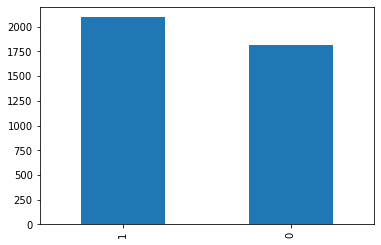

In [ ]:
df['label'].value_counts().plot.bar()

In [ ]:
# 예측기간 2011-01-03 ~ 2020-12-31
df = df.loc['2011-01-03':'2020-12-31']
df.head()
#df = df.drop(feature3, axis = 1)

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,log_return,CCI,MA5,MA10,MA20,MA60,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR,next_rtn,next_price,label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,56138.042969,56260.617188,53931.746094,54299.460938,53262.128906,620732,1271.869995,415.049988,17.610001,2070.080078,-0.024527,154.460116,53122.768750,52031.876563,49623.333984,48967.572917,1236.712248,1151.430055,1620.414990,1677.743121,55274.042427,49623.333984,43972.625542,-1348.292969,2451.441406,4.481133,-20.512837,-0.032751,53423.945871,0
2011-01-04,54789.750000,55280.039062,53196.312500,54299.460938,53262.128906,622788,1270.199951,415.579987,17.379999,2085.139893,0.000000,110.166821,53907.230469,52313.792578,50058.465039,48998.215951,1380.811404,1117.982020,1703.556372,1706.741938,55742.112759,50058.465039,44374.817319,0.000000,858.003906,3.504673,-20.512837,-0.008949,52758.554129,0
2011-01-05,53686.601562,55770.328125,53686.601562,54544.605469,53502.585938,764757,1276.560059,417.089996,17.020000,2082.550049,0.004504,104.650453,54446.547656,52742.794922,50475.210352,49034.987565,1397.787736,1046.805197,1768.837573,1733.669411,56191.121155,50475.210352,44759.299548,245.144531,-1103.148438,4.215453,-18.918935,0.015982,52215.734375,0
2011-01-06,55034.894531,55280.039062,53809.171875,54299.460938,53262.128906,779263,1273.849976,424.769989,17.400000,2077.610107,-0.004504,80.880012,54618.148438,53049.225391,50861.312500,49088.102148,1270.956296,989.796333,1780.270430,1714.897824,56514.785614,50861.312500,45207.839386,-245.144531,0.000000,6.235010,-25.806465,-0.013363,51672.915179,0
2011-01-07,54299.460938,55770.328125,54299.460938,55157.464844,54103.734375,826631,1271.500000,425.760010,17.139999,2086.199951,0.015678,89.220552,54520.090625,53416.941797,51259.671875,49165.731120,931.557834,956.362888,1837.384571,1697.467064,56945.011148,51259.671875,45574.332602,858.003906,858.003906,9.223294,-15.789515,0.015801,50779.889509,0


In [ ]:
X = df.drop(['next_price','label'], axis=1)
y = df['label']

y.shape

(2361,)

In [ ]:
X.shape

(2361, 28)

# 전처리

In [ ]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

le = LabelEncoder()        
y = le.fit_transform(y)   


In [ ]:
sum(y)/len(df) * 100

52.22363405336722

In [ ]:
X_scaled.shape

(2361, 28)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234, stratify=y)

# 함수 정의

In [ ]:
def report(clf):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Random Forest Accuracy:', np.mean(y_pred == y_test))
    ax = plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=0.5, fmt='.1f', annot=True)

In [ ]:
def feature_importance(clf):
    feature_importance = clf.feature_importances_
    # plot
    df_fi = pd.DataFrame({'columns':X.columns, 'importances':feature_importance})
    df_fi = df_fi[df_fi['importances'] > 0] # importance가 0이상인 것만 
    df_fi = df_fi.sort_values(by=['importances'], ascending=False)

    fig = plt.figure(figsize=(15,7))
    ax = sns.barplot(df_fi['columns'], df_fi['importances'])
    ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
    plt.tight_layout()
    plt.show()

# 모델

In [ ]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C= 0.1,random_state=1)
tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=41,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)

lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(tree_method='hist',random_state=41)

adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=100,
                                learning_rate = 0.01, 
                                random_state=42)

clf_labels = ['Random forest','Ada boost','XGB','LIGHTGBM']

all_clf = [ forest,adaboost,xgb,lgb]

In [ ]:
forest.fit(X_train, y_train)
lgb.fit(X_train, y_train)
xgb.fit(X_train, y_train)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

# AUC 검정

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

KeyboardInterrupt: ignored

# ROC 커브

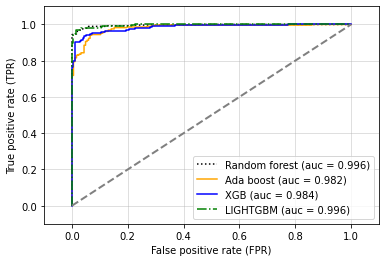

In [ ]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '-','solid','dashdot']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

In [ ]:
feature_importance = forest.feature_importances_
forest_ma = pd.DataFrame({'variable':X.columns, 'importances':feature_importance})
forest_ma.sort_values(by=['importances'],ascending=False, axis=0, inplace=True)
forest_ma['rank'] = forest_ma['importances'].rank(ascending = False)
forest_ma['term'] = '30일'
forest_ma = forest_ma[['term', 'variable', 'importances', 'rank']]
forest_ma['model'] = 'forest'
forest_ma.head()

,term,variable,importances,rank,model
9,7일,KOSPI,0.051960,1.0,forest
25,7일,ROC,0.047655,2.0,forest
18,7일,MACD,0.045902,3.0,forest
6,7일,S&P500,0.045875,4.0,forest
7,7일,SOX,0.045731,5.0,forest


In [ ]:
feature_importance = lgb.feature_importances_
lgb_ma = pd.DataFrame({'variable':X.columns, 'importances':feature_importance})
lgb_ma.sort_values(by=['importances'],ascending=False, axis=0, inplace=True)
lgb_ma['rank'] = lgb_ma['importances'].rank(ascending = False)
lgb_ma['term'] = '30일'
lgb_ma = lgb_ma[['term', 'variable', 'importances', 'rank']]
lgb_ma['model'] = 'lgb'
lgb_ma.head()

,term,variable,importances,rank,model
9,7일,KOSPI,207,1.0,lgb
18,7일,MACD,200,2.0,lgb
25,7일,ROC,198,3.0,lgb
8,7일,VIX,174,4.0,lgb
19,7일,ATR,157,5.0,lgb


In [ ]:
feature_importance = xgb.feature_importances_
xgb_ma = pd.DataFrame({'variable':X.columns, 'importances':feature_importance})
xgb_ma.sort_values(by=['importances'],ascending=False, axis=0, inplace=True)
xgb_ma['rank'] = xgb_ma['importances'].rank(ascending = False)
xgb_ma['term'] = '30일'
xgb_ma = xgb_ma[['term', 'variable', 'importances', 'rank']]
xgb_ma['model'] = 'xgb'
xgb_ma.head()

,term,variable,importances,rank,model
1,7일,High,0.069231,1.0,xgb
4,7일,Adj Close,0.066408,2.0,xgb
13,7일,MA10,0.055706,3.0,xgb
12,7일,MA5,0.053442,4.0,xgb
20,7일,ub,0.051423,5.0,xgb


In [ ]:
feature_importance = adaboost.feature_importances_
adaboost_ma = pd.DataFrame({'variable':X.columns, 'importances':feature_importance})
adaboost_ma.sort_values(by=['importances'],ascending=False, axis=0, inplace=True)
adaboost_ma['rank'] = adaboost_ma['importances'].rank(ascending = False)
adaboost_ma['term'] = '30일'
adaboost_ma = adaboost_ma[['term', 'variable', 'importances', 'rank']]
adaboost_ma['model'] = 'adaboost'
adaboost_ma.head()

,term,variable,importances,rank,model
9,7일,KOSPI,0.109420,1.0,adaboost
15,7일,MA60,0.092301,2.0,adaboost
18,7일,MACD,0.082110,3.0,adaboost
7,7일,SOX,0.074032,4.0,adaboost
11,7일,CCI,0.069551,5.0,adaboost


In [ ]:
variable = pd.concat([forest_ma, lgb_ma, xgb_ma, adaboost_ma])

In [ ]:
variable

,term,variable,importances,rank,model
9,7일,KOSPI,0.051960,1.0,forest
25,7일,ROC,0.047655,2.0,forest
18,7일,MACD,0.045902,3.0,forest
6,7일,S&P500,0.045875,4.0,forest
7,7일,SOX,0.045731,5.0,forest
...,...,...,...,...,...
0,7일,Open,0.010160,24.0,adaboost
24,7일,MTM3,0.009113,25.0,adaboost
21,7일,middle,0.009107,26.0,adaboost
14,7일,MA20,0.007546,27.0,adaboost


In [ ]:
variable.to_csv('/content/drive/MyDrive/data/이동평균선 변수 중요도_30일.csv', index = False)

# RF

In [ ]:
report(forest)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


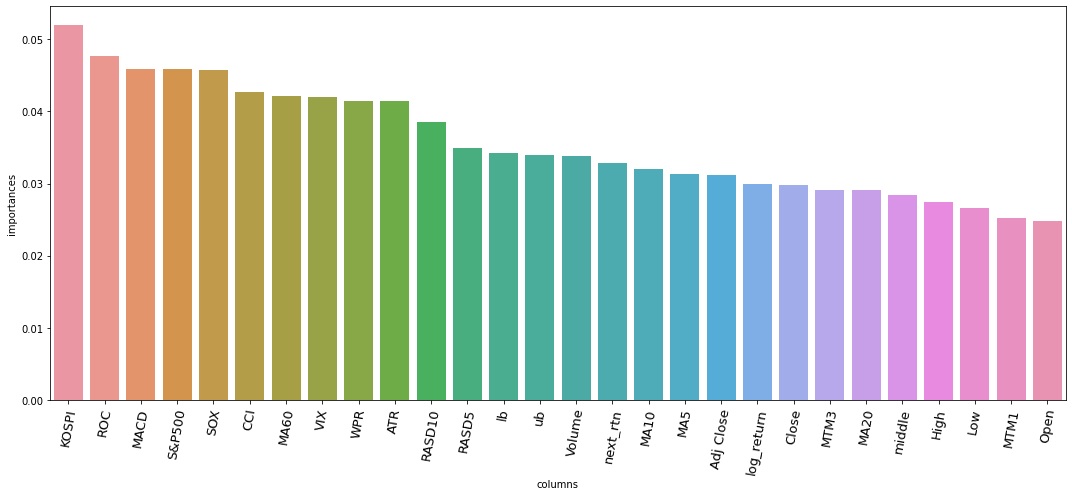

In [ ]:
feature_importance(forest)

# voting

In [ ]:
report(voting)

# DT

In [ ]:
report(tree)

In [ ]:
feature_importance(forest)

# LGBM

In [ ]:
report(lgb)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


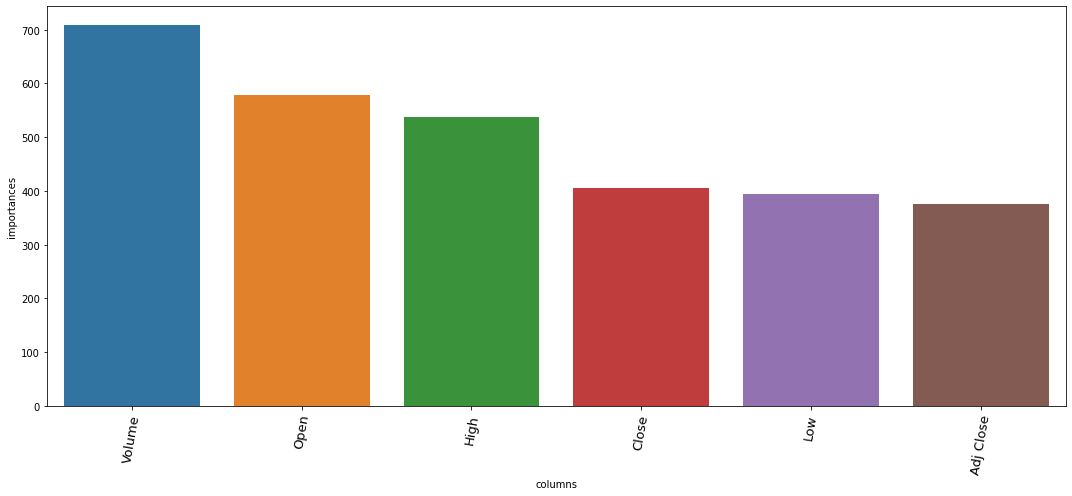

In [ ]:
feature_importance(lgb)

#XGB

In [ ]:
report(xgb)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


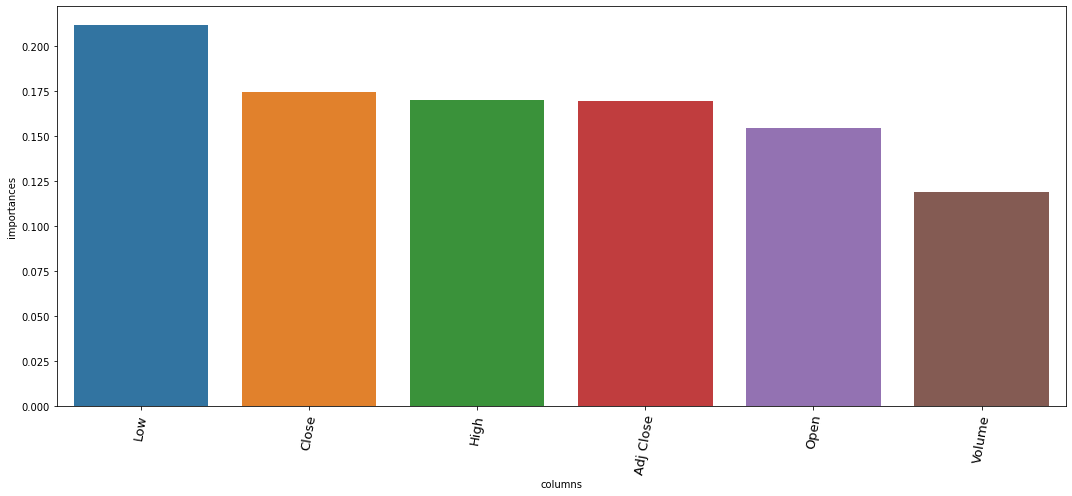

In [ ]:
feature_importance(xgb)

# ADA

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       231
           1       0.57      0.65      0.61       257

    accuracy                           0.56       488
   macro avg       0.56      0.55      0.55       488
weighted avg       0.56      0.56      0.56       488

Random Forest Accuracy: 0.5594262295081968


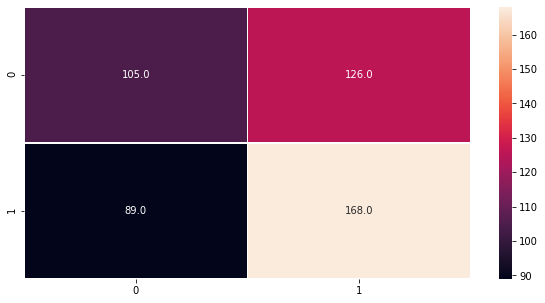

In [ ]:
report(adaboost)

              precision    recall  f1-score   support

           0       0.71      0.65      0.67       231
           1       0.70      0.76      0.73       257

    accuracy                           0.70       488
   macro avg       0.71      0.70      0.70       488
weighted avg       0.71      0.70      0.70       488

Random Forest Accuracy: 0.7049180327868853


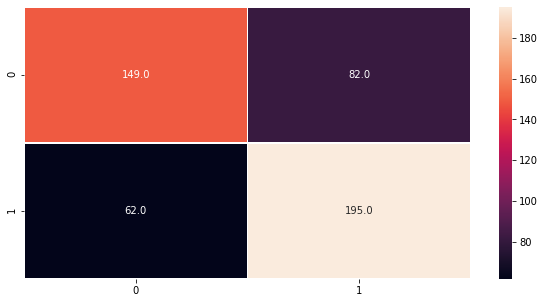

In [ ]:
report(adaboost)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


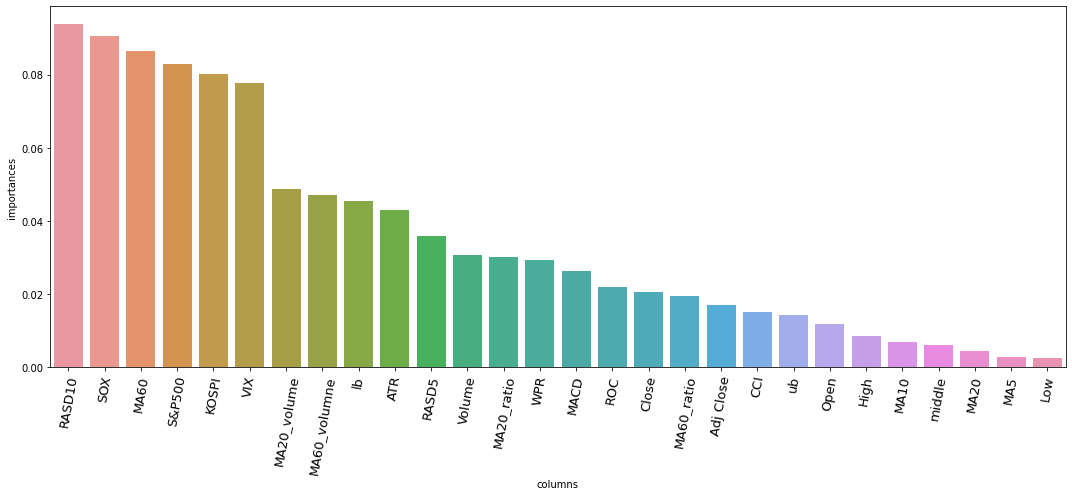

In [ ]:
feature_importance(adaboost)